In [1]:
import pandas as pd 
import numpy as np 

#visualization
import matplotlib.pyplot as plt
import seaborn as sns


#statistical analysis 
import statsmodels.api as sm

#ML models 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, IsolationForest
import xgboost as xgb

#preprocessing
from sklearn.model_selection import train_test_split  # This line was missing
from sklearn.model_selection import GroupShuffleSplit

## Reading data 

In [3]:
#reading data 
prod = pd.read_csv('digikala_ds_task_products.csv')
query = pd.read_csv('digikala_ds_task_query_product.csv')

In [4]:
prod.head(5)

,date,d_id,search_view,search_click,search_sales
0,2023-12-23,3746,21,1,0
1,2023-12-23,14993,10831,291,11
2,2023-12-23,37110,618,9,0
3,2023-12-23,86313,406,17,1
4,2023-12-23,91571,778,12,0


In [5]:
query.head(5)

,q_id,d_id,relevancy_score_1,relevancy_score_2,category_id,brand_id,price,discount,target_score
0,0,351626,1029.9591,0.692121,6044.0,719.0,2555000.0,0.0,0.621563
1,0,392222,1029.9591,0.273830,6044.0,719.0,2450000.0,0.0,0.589059
2,0,475019,1029.9591,0.316562,6044.0,719.0,NaN,0.0,0.584239
3,0,480445,1029.9591,0.318788,6044.0,719.0,1317500.0,15.0,0.579027
4,0,286374,1029.9591,0.397037,6044.0,719.0,5380000.0,0.0,0.577228


## Categorical Value handling: 
1. We have not used one-hot encoding for `category_id` due to its high cardinality, meaning it contains a large number of unique values causes a high number of features. Instead, we applied frequency encoding conditioned on `category_id` values (for fixed value of `q_id`)
2. We do same thing for `brand_id` as well.


In [6]:
# calculate frequencies of category_id and brand_id within each query
frequencies = query.groupby('q_id')['category_id'].transform(lambda x: x.map(x.value_counts(normalize=True)))
query['category_id'] = frequencies
frequencies = query.groupby('q_id')['brand_id'].transform(lambda x: x.map(x.value_counts(normalize=True)))
query['brand_id'] = frequencies

In [7]:
query.head(5)

,q_id,d_id,relevancy_score_1,relevancy_score_2,category_id,brand_id,price,discount,target_score
0,0,351626,1029.9591,0.692121,1.0,1.0,2555000.0,0.0,0.621563
1,0,392222,1029.9591,0.273830,1.0,1.0,2450000.0,0.0,0.589059
2,0,475019,1029.9591,0.316562,1.0,1.0,NaN,0.0,0.584239
3,0,480445,1029.9591,0.318788,1.0,1.0,1317500.0,15.0,0.579027
4,0,286374,1029.9591,0.397037,1.0,1.0,5380000.0,0.0,0.577228


## Feature Augmentation:
In this section, we enhance our dataset to facilitate the machine learning model's task. Specifically, for a **given query**, we augment the dataset with the ranks of `relevancy_score_1`, `relevancy_score_2`, `price`, and `discount` associated with that specific query. This addition is predicated on the belief that these ranked features encapsulate crucial information pertinent to our task.

In [8]:
query['relevancy_score_1_rank'] = query.groupby('q_id').relevancy_score_1.rank()
query['relevancy_score_2_rank'] = query.groupby('q_id').relevancy_score_2.rank()
query['price_rank'] = query.groupby('q_id').price.rank()
query['discount_rank'] = query.groupby('q_id').discount.rank()

## Integrating Product Information into Queries:
1. A key insight emerged regarding the introduction of a new feature: the ratio defined by `search_click/search_view`. This metric, indicating the proportion of user clicks to views for a displayed document, has been identified as crucial and thus added to the product dataset.

2. To leverage product-related data, we are merging product information with query data. Given the temporal nature of product data, we chose to utilize the `mean` and `standard deviation (std)` of each product's attributes over time as features. **Future Consideration:** A refined approach could involve a more sophisticated use of this temporal data, such as identifying the optimal time interval for feature extraction. However, this would require time-dependent query data, a dimension not currently explored in our analysis.

3. Following the merger of product and query datasets, we apply the same methodology as described earlier to rank these newly integrated features, enhancing the dataset further.


In [9]:
#acceptance ratio
epsilon = 1e-4 #to prevent inf values
prod['acceptance_ratio'] = prod['search_click']/(prod['search_view']+epsilon) 

In [10]:
# finding mean of features for each d_id  
prod_grouped = prod.groupby('d_id').mean(numeric_only=True)
prod_grouped = prod.groupby('d_id').aggregate({'search_view':[np.mean,np.std],'search_click':[np.mean,np.std]
                                              ,'search_sales':[np.mean,np.std],'acceptance_ratio':[np.mean,np.std]})
# convert MultiIndex columns to single-level index
prod_grouped.columns = ['_'.join(col).rstrip('_') for col in prod_grouped.columns.values]
prod_grouped

/var/folders/d3/lb603w9160b7tt39y9jn4_680000gn/T/ipykernel_22689/1299343821.py:3: FutureWarning: The provided callable <function mean at 0x105490b80> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  prod_grouped = prod.groupby('d_id').aggregate({'search_view':[np.mean,np.std],'search_click':[np.mean,np.std]
/var/folders/d3/lb603w9160b7tt39y9jn4_680000gn/T/ipykernel_22689/1299343821.py:3: FutureWarning: The provided callable <function std at 0x105490cc0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  prod_grouped = prod.groupby('d_id').aggregate({'search_view':[np.mean,np.std],'search_click':[np.mean,np.std]


,search_view_mean,search_view_std,search_click_mean,search_click_std,search_sales_mean,search_sales_std,acceptance_ratio_mean,acceptance_ratio_std
d_id,,,,,,,,
24,155.900000,26.631018,1.900000,1.286684,0.0,0.000000,0.011587,0.007774
153,80.000000,11.135529,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
183,690.200000,59.122848,7.000000,1.632993,0.0,0.000000,0.010138,0.002261
201,168.400000,14.292189,3.400000,1.349897,0.1,0.316228,0.019989,0.007216
290,41.285714,8.380817,0.428571,0.534522,0.0,0.000000,0.010759,0.013563
...,...,...,...,...,...,...,...,...
534208,48.666667,10.214369,6.000000,2.000000,0.0,0.000000,0.121391,0.018764
534209,51.000000,NaN,7.000000,NaN,0.0,NaN,0.137255,NaN
534210,50.000000,2.828427,6.500000,3.535534,0.0,0.000000,0.132211,0.078190


In [11]:
#merging dfs on document id 
merged_df = pd.merge(query, prod_grouped, on='d_id', how='left')
merged_df

,q_id,d_id,relevancy_score_1,relevancy_score_2,category_id,brand_id,price,discount,target_score,relevancy_score_1_rank,...,price_rank,discount_rank,search_view_mean,search_view_std,search_click_mean,search_click_std,search_sales_mean,search_sales_std,acceptance_ratio_mean,acceptance_ratio_std
0,0,351626,1029.9591,0.692121,1.000,1.0,2555000.0,0.0,0.621563,20.5,...,7.0,20.0,1851.6,251.503567,88.9,26.601796,0.7,0.823273,0.047858,0.011403
1,0,392222,1029.9591,0.273830,1.000,1.0,2450000.0,0.0,0.589059,20.5,...,5.5,20.0,1660.3,209.068330,101.8,22.299975,0.4,0.699206,0.060965,0.008247
2,0,475019,1029.9591,0.316562,1.000,1.0,NaN,0.0,0.584239,20.5,...,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,480445,1029.9591,0.318788,1.000,1.0,1317500.0,15.0,0.579027,20.5,...,1.0,40.0,728.6,170.300519,27.3,9.989439,0.1,0.316228,0.036558,0.006885
4,0,286374,1029.9591,0.397037,1.000,1.0,5380000.0,0.0,0.577228,20.5,...,8.0,20.0,1079.8,212.732383,48.2,10.622827,0.0,0.000000,0.044706,0.004899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291255,8564,126490,272.2497,0.327581,0.875,1.0,NaN,0.0,0.298936,17.0,...,NaN,20.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291256,8564,69851,272.2497,0.220030,0.875,1.0,NaN,0.0,0.349237,17.0,...,NaN,20.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291257,8564,69853,272.2497,0.271971,0.875,1.0,NaN,0.0,0.459472,17.0,...,NaN,20.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291258,8564,69857,272.2497,0.716489,0.875,1.0,NaN,0.0,0.076308,17.0,...,NaN,20.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
#adding ranks 
merged_df['search_view_rank'] = merged_df.groupby('q_id').search_view_mean.rank()
merged_df['search_click_rank'] = merged_df.groupby('q_id').search_click_mean.rank()
merged_df['search_sales_rank'] = merged_df.groupby('q_id').search_sales_mean.rank()
merged_df['acceptance_ratio_rank'] = merged_df.groupby('q_id').acceptance_ratio_mean.rank()

In [13]:
merged_df.head(5)

,q_id,d_id,relevancy_score_1,relevancy_score_2,category_id,brand_id,price,discount,target_score,relevancy_score_1_rank,...,search_click_mean,search_click_std,search_sales_mean,search_sales_std,acceptance_ratio_mean,acceptance_ratio_std,search_view_rank,search_click_rank,search_sales_rank,acceptance_ratio_rank
0,0,351626,1029.9591,0.692121,1.0,1.0,2555000.0,0.0,0.621563,20.5,...,88.9,26.601796,0.7,0.823273,0.047858,0.011403,10.0,9.0,10.0,9.0
1,0,392222,1029.9591,0.273830,1.0,1.0,2450000.0,0.0,0.589059,20.5,...,101.8,22.299975,0.4,0.699206,0.060965,0.008247,9.0,10.0,9.0,10.0
2,0,475019,1029.9591,0.316562,1.0,1.0,NaN,0.0,0.584239,20.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,480445,1029.9591,0.318788,1.0,1.0,1317500.0,15.0,0.579027,20.5,...,27.3,9.989439,0.1,0.316228,0.036558,0.006885,7.0,7.0,7.0,7.0
4,0,286374,1029.9591,0.397037,1.0,1.0,5380000.0,0.0,0.577228,20.5,...,48.2,10.622827,0.0,0.000000,0.044706,0.004899,8.0,8.0,3.5,8.0


# EDA

In [14]:
merged_df.describe()

,q_id,d_id,relevancy_score_1,relevancy_score_2,category_id,brand_id,price,discount,target_score,relevancy_score_1_rank,...,search_click_mean,search_click_std,search_sales_mean,search_sales_std,acceptance_ratio_mean,acceptance_ratio_std,search_view_rank,search_click_rank,search_sales_rank,acceptance_ratio_rank
count,291260.000000,291260.000000,291260.000000,236490.000000,291254.000000,291254.000000,1.237590e+05,291254.000000,2.912600e+05,291260.000000,...,132142.000000,115973.000000,132142.000000,115973.000000,132142.000000,115973.000000,132142.000000,132142.000000,132142.000000,132142.000000
mean,4308.047638,279340.143006,1810.639675,0.588295,0.800064,0.652531,1.652480e+07,1.760333,3.120549e-01,33.103001,...,14.804804,6.535806,0.189641,0.280893,0.524401,0.637242,16.461246,16.461246,16.461246,16.461246
std,2457.983031,156590.439551,1906.188564,0.273496,0.289120,0.356090,7.132135e+07,6.396666,1.911823e-01,24.649859,...,47.447109,19.180630,0.885240,1.088595,55.785178,55.754567,13.283688,13.275286,11.785086,13.279762
min,0.000000,24.000000,6.627294,0.057973,0.010000,0.010000,3.300000e+04,0.000000,4.446027e-07,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,2111.000000,143190.250000,744.380500,0.327185,0.714286,0.350000,7.900000e+05,0.000000,1.507463e-01,15.000000,...,2.000000,1.354006,0.000000,0.000000,0.011820,0.004617,6.500000,6.500000,8.000000,6.000000
50%,4395.000000,286966.500000,959.472000,0.602607,0.950000,0.800000,2.096000e+06,0.000000,3.024550e-01,26.000000,...,4.625000,2.469818,0.000000,0.000000,0.019488,0.007601,13.000000,13.000000,13.500000,13.000000
75%,6388.000000,418030.500000,2855.369800,0.859522,1.000000,0.960000,7.200000e+06,0.000000,4.543699e-01,44.500000,...,11.400000,5.292552,0.111111,0.408248,0.030506,0.012593,23.000000,23.000000,21.000000,23.000000
max,8564.000000,534246.000000,34832.850000,0.989856,1.000000,1.000000,6.847000e+09,84.000000,1.406977e+00,100.000000,...,2457.900000,1319.570557,61.700000,66.191725,10000.000000,7071.067812,98.000000,98.000000,98.000000,98.000000


## Correlation Analysis:
The heatmap of feature correlations reveals several key insights:
1. The `rank` columns we incorporated into our features exhibit a higher correlation with `target_score` compared to other features, indicating their significance for our problem.
2. To mitigate the issue of multicollinearity, we will exclude one feature from each pair exhibiting a correlation greater than 0.8.


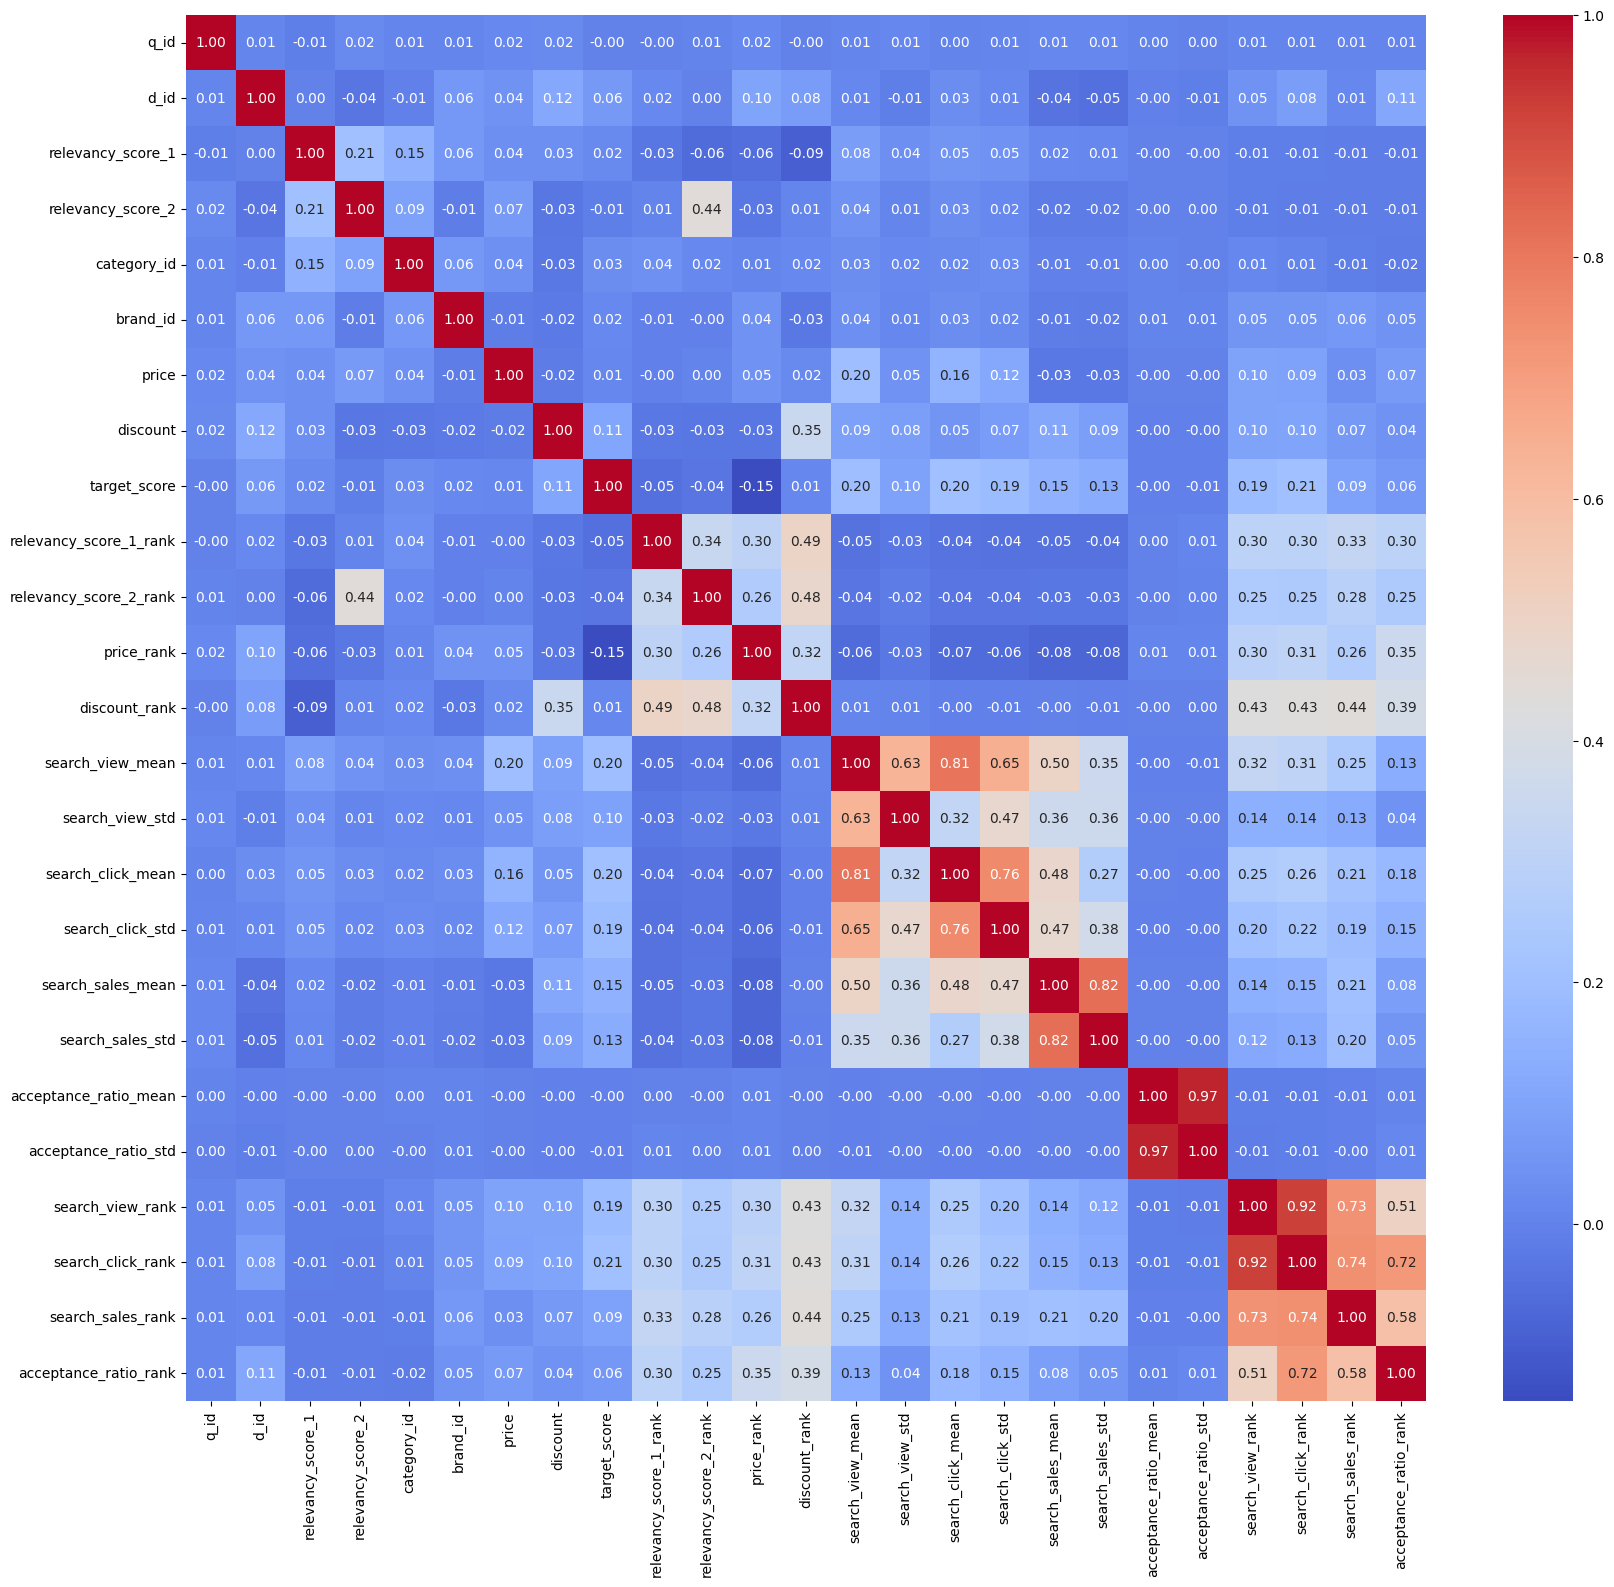

In [15]:
# calculate the correlation matrix
corr = merged_df.corr()

# plotting
plt.figure(figsize=(20, 18))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', 
            xticklabels=corr.columns, yticklabels=corr.columns)

# show the plot
plt.show()

In [16]:
#drop features 
merged_df_reduced = merged_df.drop(columns=['search_click_rank','acceptance_ratio_std','search_sales_std','search_click_mean'])
merged_df_reduced.head(5)

,q_id,d_id,relevancy_score_1,relevancy_score_2,category_id,brand_id,price,discount,target_score,relevancy_score_1_rank,...,price_rank,discount_rank,search_view_mean,search_view_std,search_click_std,search_sales_mean,acceptance_ratio_mean,search_view_rank,search_sales_rank,acceptance_ratio_rank
0,0,351626,1029.9591,0.692121,1.0,1.0,2555000.0,0.0,0.621563,20.5,...,7.0,20.0,1851.6,251.503567,26.601796,0.7,0.047858,10.0,10.0,9.0
1,0,392222,1029.9591,0.273830,1.0,1.0,2450000.0,0.0,0.589059,20.5,...,5.5,20.0,1660.3,209.068330,22.299975,0.4,0.060965,9.0,9.0,10.0
2,0,475019,1029.9591,0.316562,1.0,1.0,NaN,0.0,0.584239,20.5,...,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,480445,1029.9591,0.318788,1.0,1.0,1317500.0,15.0,0.579027,20.5,...,1.0,40.0,728.6,170.300519,9.989439,0.1,0.036558,7.0,7.0,7.0
4,0,286374,1029.9591,0.397037,1.0,1.0,5380000.0,0.0,0.577228,20.5,...,8.0,20.0,1079.8,212.732383,10.622827,0.0,0.044706,8.0,3.5,8.0


## Missing Value Analysis:
Our analysis indicates that both the `price` and several product-related columns (derived from the product table) have a significant proportion of missing values, exceeding 55%. Given the absence of other features strongly correlated with these columns and considering the substantial percentage of missing data, we need to opted for machine learning approaches capable of managing missing values intrinsically, such as XGBoost.

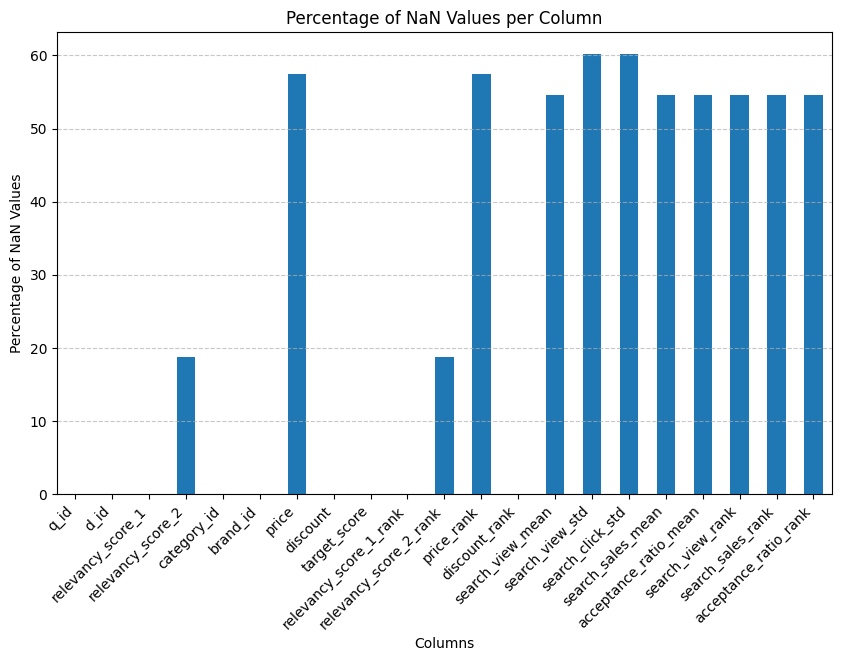

In [17]:
# calculate the percentage of NaN values for each column
nan_percentage = merged_df_reduced.isnull().mean() * 100

# plotting
plt.figure(figsize=(10, 6))
nan_percentage.plot(kind='bar')
plt.title('Percentage of NaN Values per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of NaN Values')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

## Histograms & Boxplots:
0. We have generated histograms and boxplots for a **specific query** to understand the distribution of our data better.
1. Although the box plots indicate the presence of numerous outliers, the histograms reveal highly skewed distributions. This observation suggests that not all outliers identified by the box plots should be indiscriminately removed.
2. Given the extensive skewness and varying behaviors across distributions, it is impractical to make assumptions regarding the data's distribution for outlier removal. Therefore, we require an outlier detection method that operates without prior assumed distribution and should calibrate the outlier ratio conservatively due to the skewness.
3. Following from point 2, we selected `Isolation Forest (iForest)` for outlier detection. 

In [18]:
#grouping by query 
grouped_by_query = merged_df_reduced.groupby('q_id').mean(numeric_only=True)

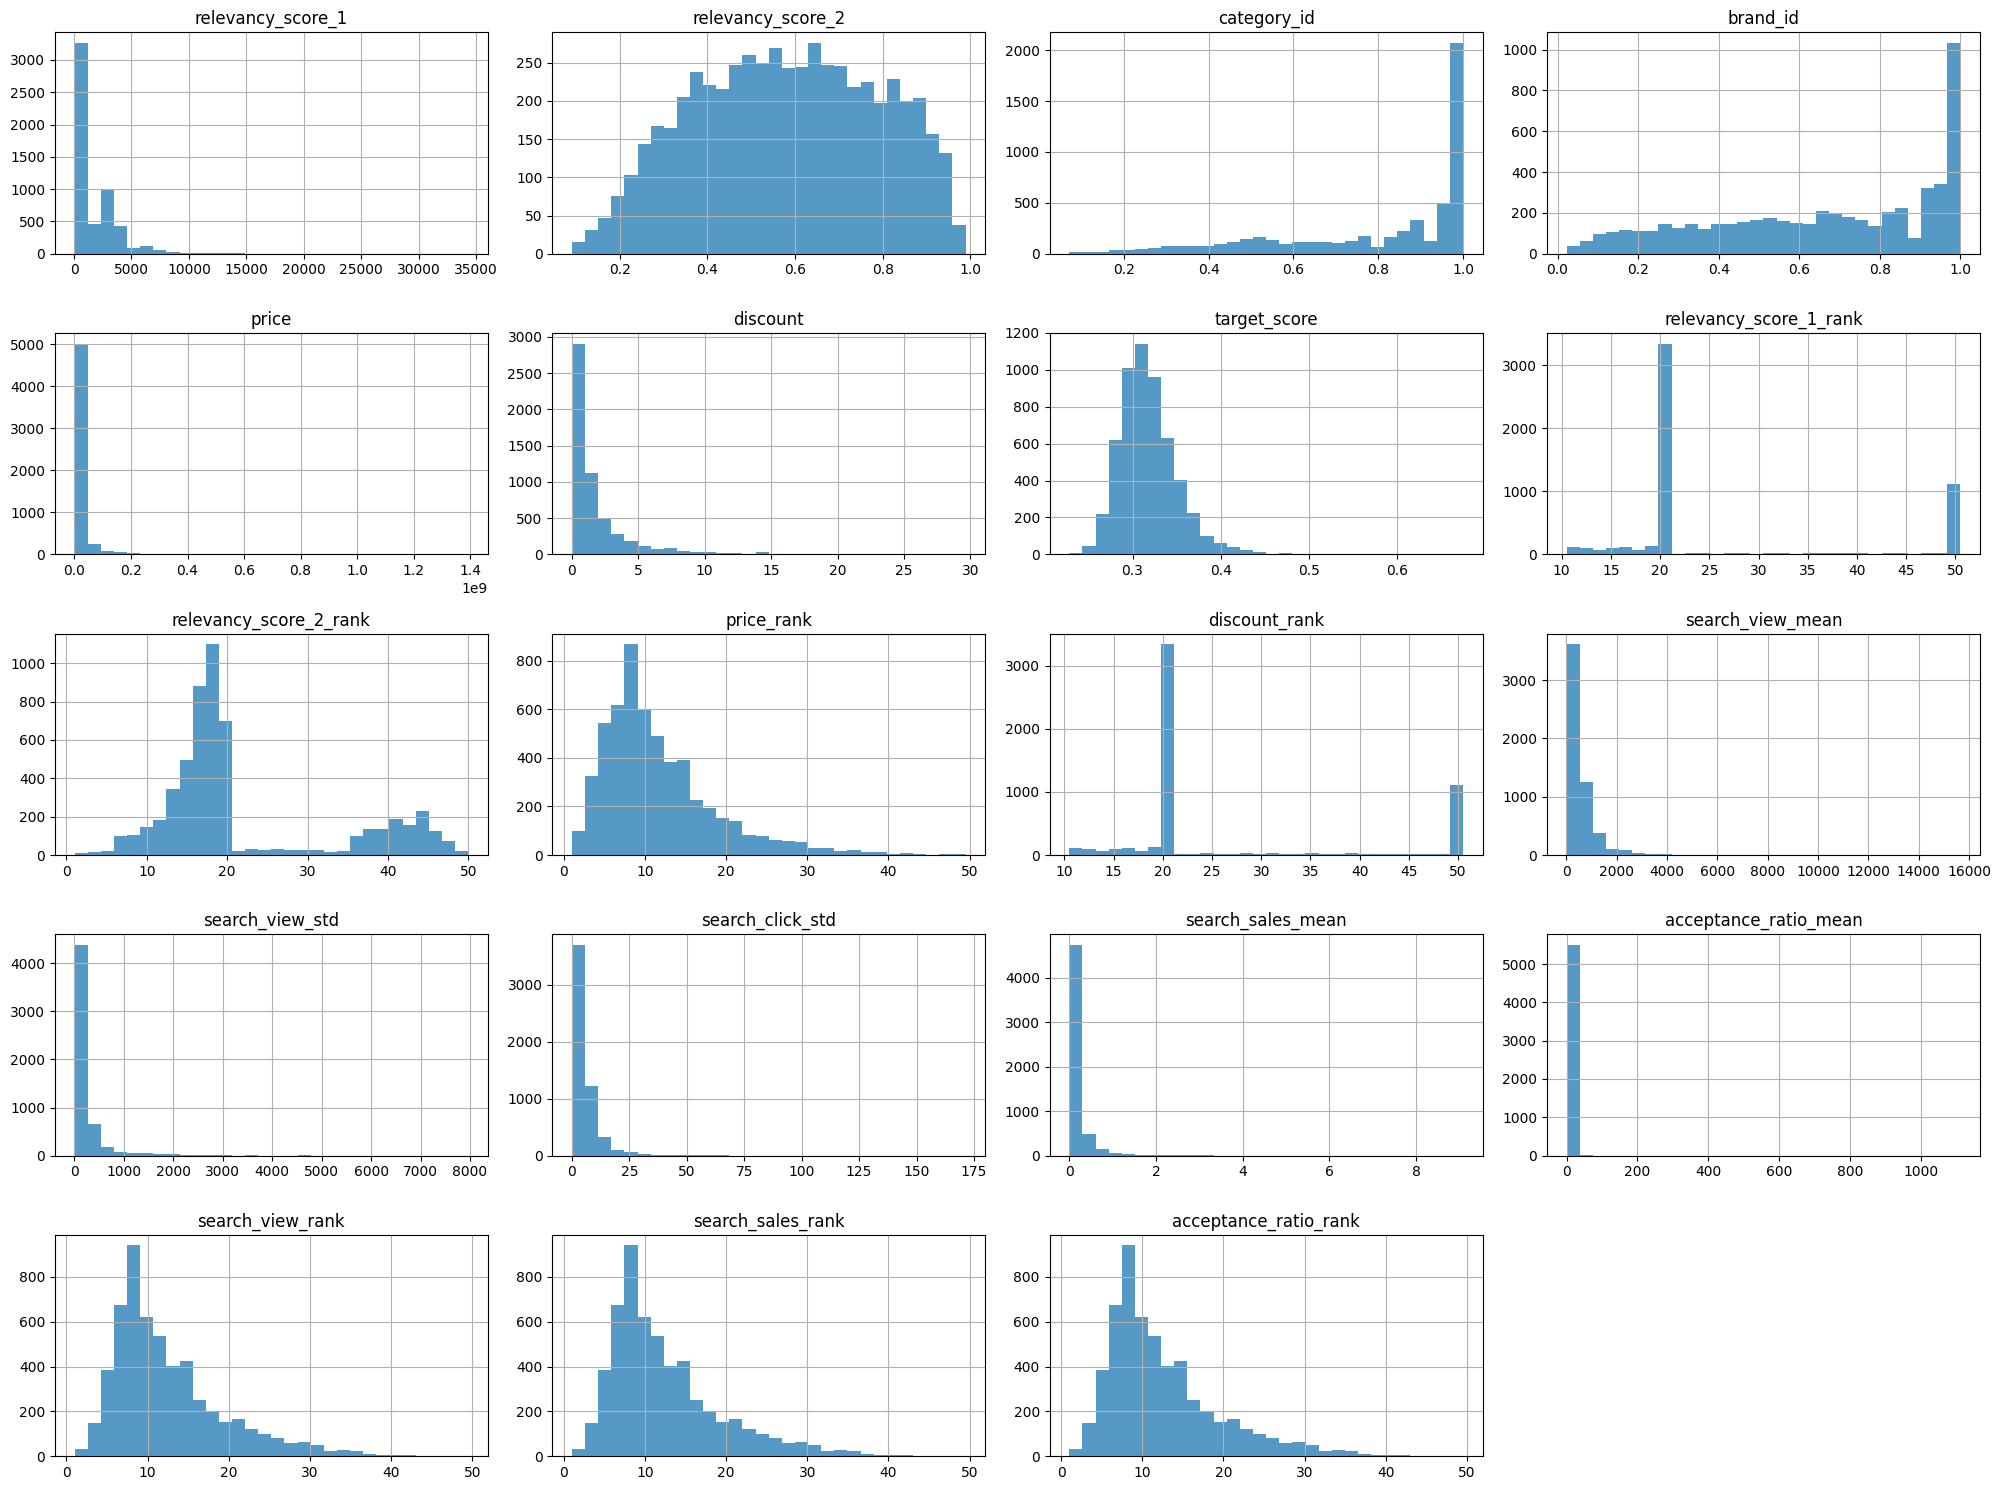

In [19]:
# plot histograms for all columns
grouped_by_query.drop(['d_id'],axis=1).hist(bins=30, figsize=(20, 15), layout=(-1, 4), alpha=0.75)

# show the plot
plt.tight_layout()
plt.show()

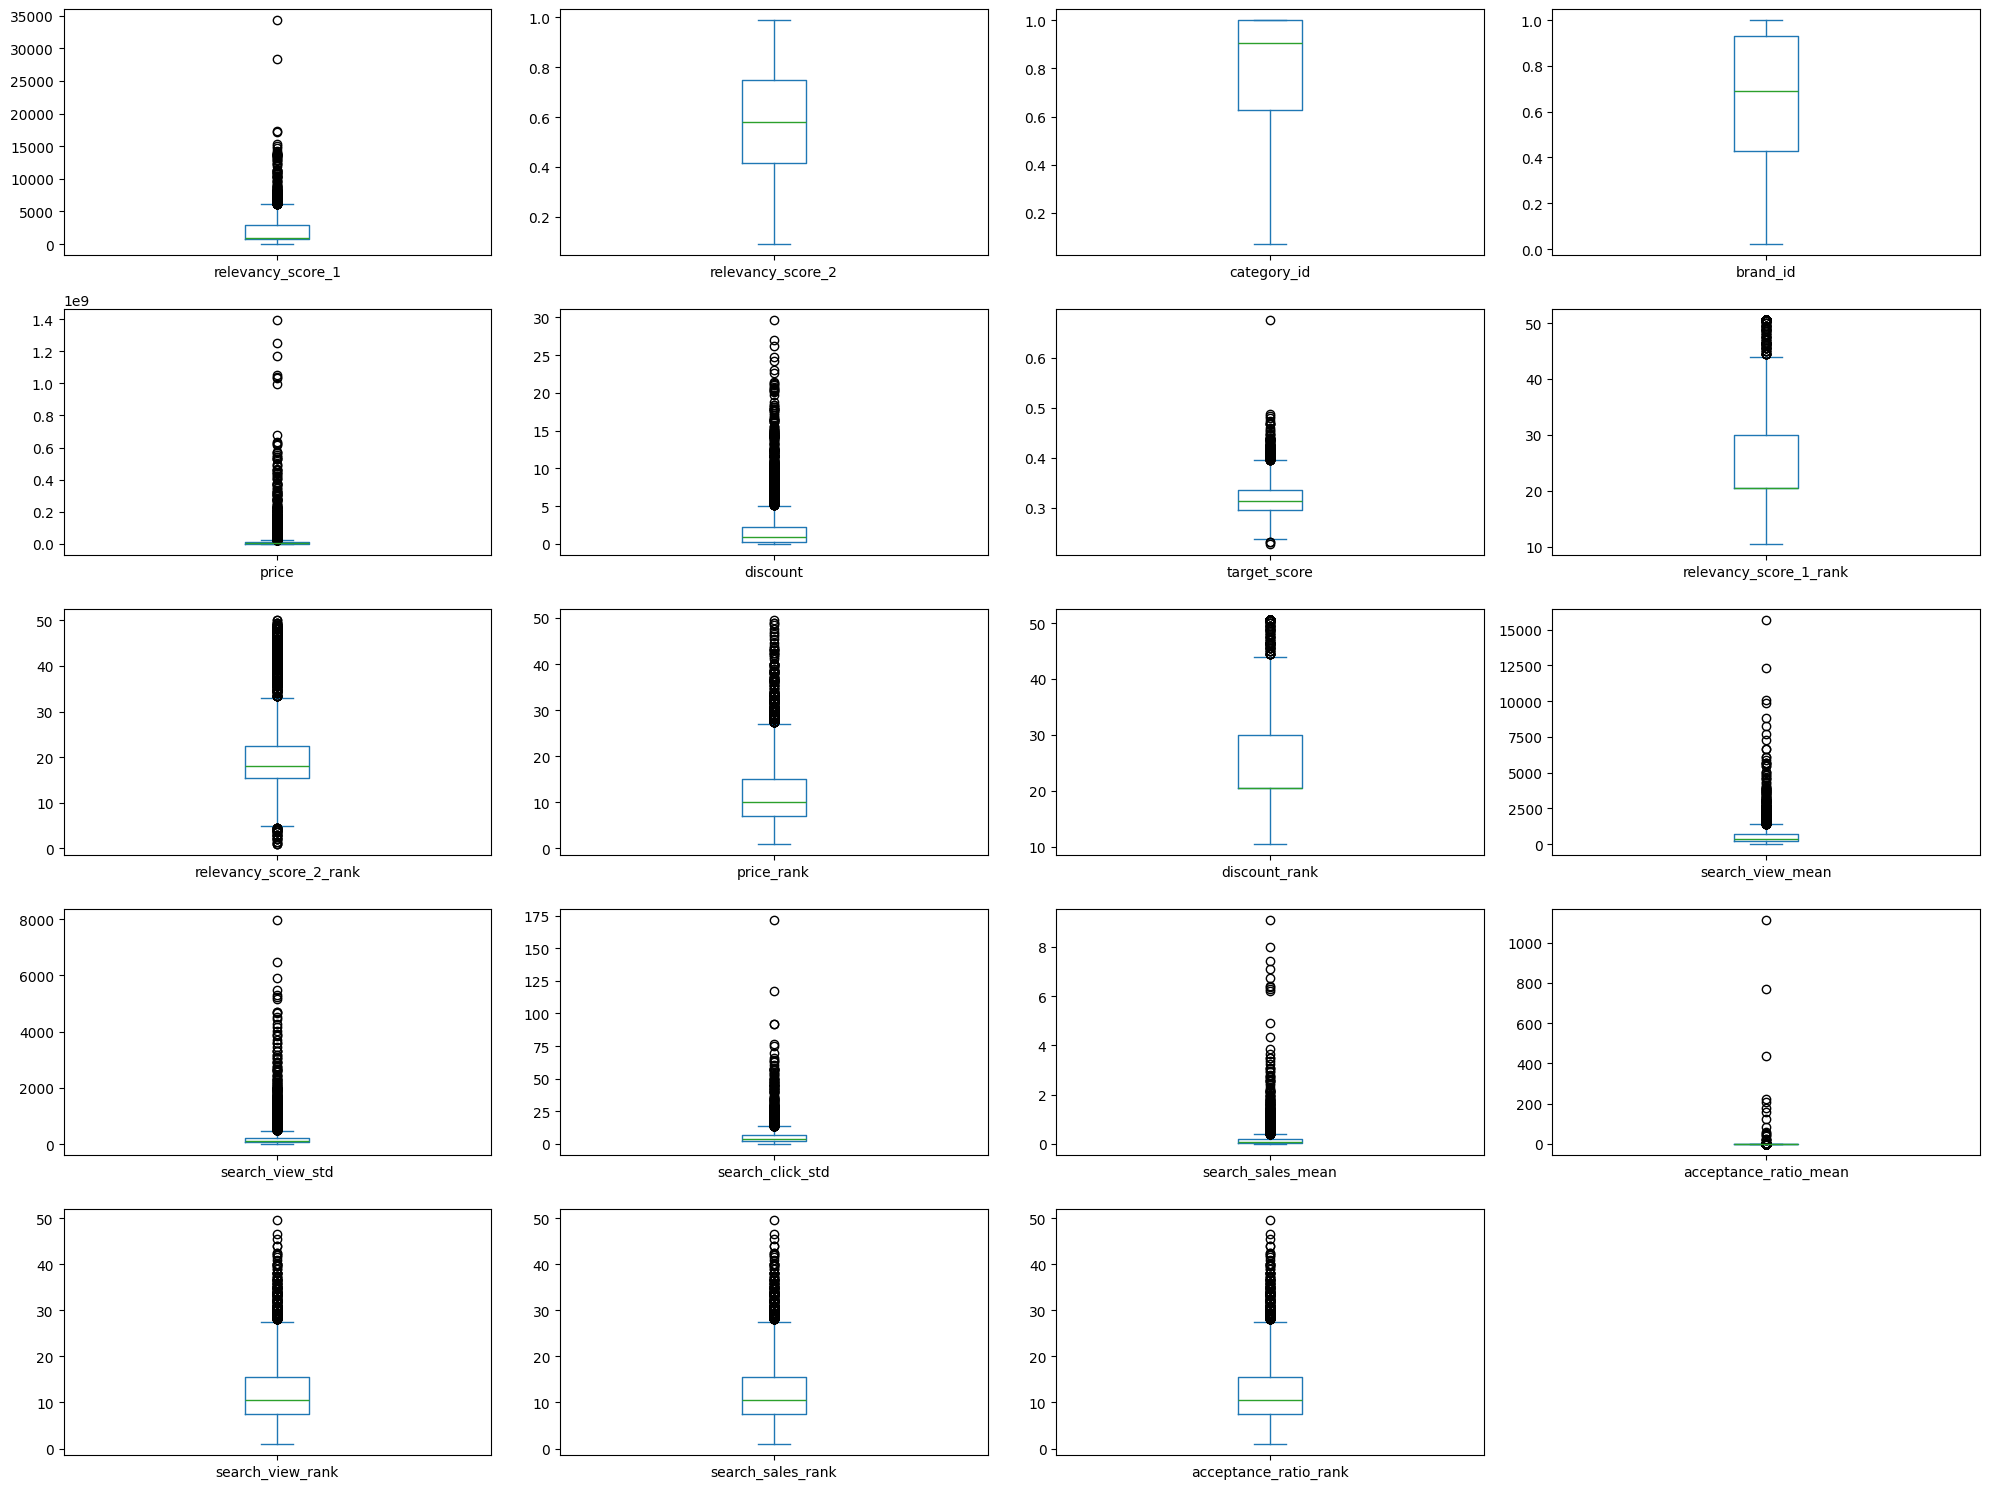

In [20]:
grouped_by_query.drop(['d_id'],axis=1).plot(kind='box', subplots=True, layout=(-1, 4), figsize=(20, 15), sharex=False, sharey=False)
plt.tight_layout()  
plt.show()

## Outlier Detection:
Following our observations in the previous section, we will now employ `Isolation Forest (iForest)` to identify and remove outlier queries:
1. As a preliminary step, all features will be scaled to fall within the range of (0,1). This normalization is crucial to enhance the effectiveness of `iForest` by ensuring equal weightage to all features.
2. Given that `iForest` cannot process missing values, we will impute such values with the mean of their respective features. This approach to filling missing values is chosen because imputing with the average will not skew the results of the outlier detection.


In [21]:
#scaling between 0 and 1
grouped_by_query = (grouped_by_query - np.min(grouped_by_query)) / (np.max(grouped_by_query) - np.min(grouped_by_query))

In [22]:
#fill missing values 
grouped_by_query = grouped_by_query.fillna(np.mean(grouped_by_query))

In [23]:
#fitting and using iForest
outlier_detector = IsolationForest(contamination=0.01)
if_outlier = outlier_detector.fit_predict(grouped_by_query)

In [24]:
#determining which queries are outliers
grouped_by_query['outlier'] = if_outlier
q_ids_to_remove = grouped_by_query[grouped_by_query['outlier'] == -1].index.values

In [25]:
#remove outliers
merged_df_reduced_outlier_removed = merged_df_reduced[~merged_df_reduced['q_id'].isin(q_ids_to_remove)]
merged_df_reduced_outlier_removed

,q_id,d_id,relevancy_score_1,relevancy_score_2,category_id,brand_id,price,discount,target_score,relevancy_score_1_rank,...,price_rank,discount_rank,search_view_mean,search_view_std,search_click_std,search_sales_mean,acceptance_ratio_mean,search_view_rank,search_sales_rank,acceptance_ratio_rank
0,0,351626,1029.9591,0.692121,1.000,1.0,2555000.0,0.0,0.621563,20.5,...,7.0,20.0,1851.6,251.503567,26.601796,0.7,0.047858,10.0,10.0,9.0
1,0,392222,1029.9591,0.273830,1.000,1.0,2450000.0,0.0,0.589059,20.5,...,5.5,20.0,1660.3,209.068330,22.299975,0.4,0.060965,9.0,9.0,10.0
2,0,475019,1029.9591,0.316562,1.000,1.0,NaN,0.0,0.584239,20.5,...,NaN,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,480445,1029.9591,0.318788,1.000,1.0,1317500.0,15.0,0.579027,20.5,...,1.0,40.0,728.6,170.300519,9.989439,0.1,0.036558,7.0,7.0,7.0
4,0,286374,1029.9591,0.397037,1.000,1.0,5380000.0,0.0,0.577228,20.5,...,8.0,20.0,1079.8,212.732383,10.622827,0.0,0.044706,8.0,3.5,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291255,8564,126490,272.2497,0.327581,0.875,1.0,NaN,0.0,0.298936,17.0,...,NaN,20.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291256,8564,69851,272.2497,0.220030,0.875,1.0,NaN,0.0,0.349237,17.0,...,NaN,20.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291257,8564,69853,272.2497,0.271971,0.875,1.0,NaN,0.0,0.459472,17.0,...,NaN,20.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
291258,8564,69857,272.2497,0.716489,0.875,1.0,NaN,0.0,0.076308,17.0,...,NaN,20.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature Selection
Certain columns, including `price` and those related to product information, exhibit a substantial portion of missing values, exceeding 50%. In response, our strategy leans towards employing machine learning algorithms adept at managing missing data autonomously. Consequently, we select `XGBRanker` from the XGBoost library, renowned for its intrinsic capability to handle missing values efficiently. Initially, we deploy `XGBRanker` in its default configuration, without hyperparameter tuning, to guide the feature selection process.


In [26]:
#to split train and test without conflict with `q_id`s 
gss = GroupShuffleSplit(test_size=0.20, n_splits=1, random_state = 0).split(merged_df_reduced_outlier_removed, groups=merged_df_reduced_outlier_removed['q_id'])

X_train_inds, X_test_inds = next(gss)

train_data= merged_df_reduced_outlier_removed.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['q_id','d_id','target_score'])]
y_train = train_data.loc[:, train_data.columns.isin(['target_score'])]

groups = train_data.groupby('q_id').size().to_frame('size')['size'].to_numpy()


test_data= merged_df_reduced_outlier_removed.iloc[X_test_inds]

#We need to keep the id for later predictions
X_test = test_data.loc[:, ~test_data.columns.isin(['target_score','d_id'])]
y_test = test_data.loc[:, test_data.columns.isin(['target_score'])]

Given the task's requirement to optimize for `target_score`, we set objective of model as pairwise

In [27]:
model = xgb.XGBRanker(  
    objective='rank:pairwise',
    )
model.fit(X_train, y_train, group=groups, verbose=True)

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
          importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

Now we will use our model to remove those features that have low importance (th = 200)

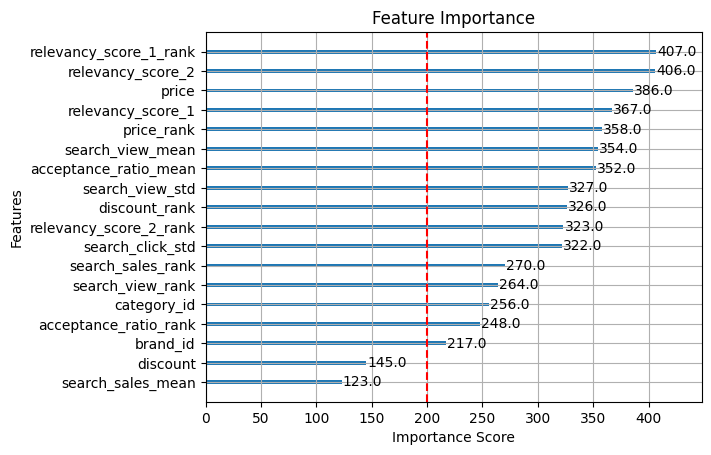

In [28]:
# Plot feature importance
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.axvline(x=200, color='r', linestyle='--') # Threshold for statistical significance
plt.show()

In [29]:
merged_df_reduced_outlier_removed.drop(['search_sales_mean','discount'],axis=1,inplace=True)

/var/folders/d3/lb603w9160b7tt39y9jn4_680000gn/T/ipykernel_22689/4017744614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_reduced_outlier_removed.drop(['search_sales_mean','discount'],axis=1,inplace=True)


### Saving data

In [30]:
merged_df_reduced_outlier_removed.to_csv('cleaned_data.csv')